# Import and setup

In [1]:
import json
import re
import pandas as pd
import numpy as np
import dask.bag as db
from matplotlib import pyplot as plt
from pylab import rcParams
from matplotlib import rc
import seaborn as sns

In [2]:
rcParams['figure.figsize'] = 15, 6
RANDOM_SEED = 9
np.random.seed(RANDOM_SEED)
%matplotlib inline

# Look at the arxiv metadata

In [3]:
info = db.read_text("arxiv-metadata-oai-snapshot.json").map(json.loads)

In [4]:
first_v = lambda x: x['versions'][0]['created']

## Keep papers from years in between

In [5]:
trim = lambda x: {'id': x['id'],
                  'category': x['categories'].split(' '),
                 'abstract': x['abstract']}

In [6]:
info_spans = info.filter(lambda x: int(first_v(x).split(' ')[3]) in [2011, 2012, 2013, 2014, 2015, 2016, 2017]).map(trim).compute()

In [7]:
submissions = pd.DataFrame(info_spans)
submissions['year'] = submissions.id.apply(lambda x: x[:2])
submissions = submissions[submissions.year.apply(lambda x: x in ['11', '12', '13', '14', '15', '16', '17'])]

### Only look at general category containing all sub-categories

In [8]:
submissions['category'] = submissions.category.apply(lambda x: [a.split('.')[0] for a in x])
submissions['category'] = submissions.category.apply(lambda x: list(dict.fromkeys(x)))

### Separate categories into submission category and cross-lists

In [9]:
submissions['cross_lists']=submissions.category.apply(lambda x: x[1:])
submissions['category']=submissions.category.apply(lambda x: x[0])

## look at number of submissions per category per year

In [10]:
keepcategories =['math', 'astro-ph', 'hep-ph', 'math-ph', 'hep-th', 'physics', 'quant-ph', 'cs', 'cond-mat', 'nlin', 'q-bio', 'nucl-th', 'hep-ex', 'gr-qc']

### only keep those categories and balance the dataset

In [11]:
submissionscut = submissions[submissions.category.apply(lambda x: x in keepcategories)]

In [41]:
submissions_single_cat = submissionscut[submissionscut.cross_lists.apply(lambda x: len(x) == 0)]

In [42]:
submissions_single_cat.head()

,id,category,abstract,year,cross_lists
1,1101.0311,math,This short note presents a peculiar generali...,11,[]
2,1101.0312,cond-mat,The Boltzmann constant was measured by compa...,11,[]
3,1101.0313,math,A geometric version of the Poincar\'e Lemma ...,11,[]
4,1101.0314,cond-mat,The topological magnetoelectric effect (TME)...,11,[]
5,1101.0315,physics,We have studied the context and development ...,11,[]


In [43]:
MIN_CAT = 75
arxiv_sample = submissionscut.groupby(['year', 'category']).sample(n=MIN_CAT, random_state=RANDOM_SEED)
arxiv_sample_sincat = submissions_single_cat.groupby(['year', 'category']).sample(n=MIN_CAT, random_state=RANDOM_SEED, replace=True)

Some categories do not have 75 single-category submissions per year so we use replace.  However since these are only being used to calculate accuracy, not training, this bloat doesn't hurt us.

In [44]:
submissions_single_cat.groupby(['year', 'category'])['category'].count()

year  category
11    astro-ph    10166
      cond-mat     9312
      cs           4737
      gr-qc         761
      hep-ex        918
                  ...  
17    nlin          488
      nucl-th       624
      physics      7152
      q-bio         933
      quant-ph     3100
Name: category, Length: 91, dtype: int64

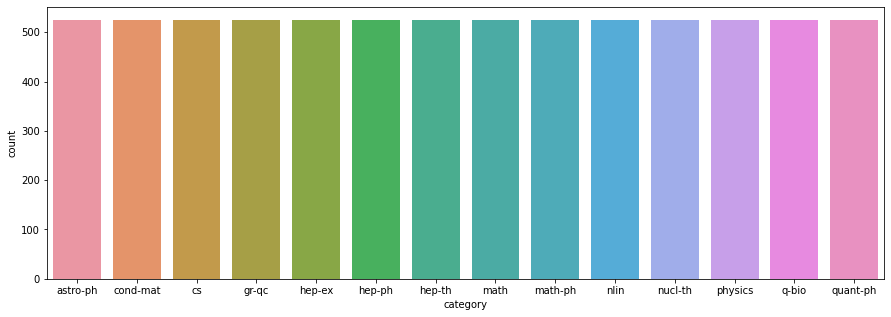

In [13]:
plt.figure(figsize=(15,5))
sns.countplot(x=arxiv_sample.category)
plt.xlabel('category');

# CLEAN
- remove newline characters
- rewrite $LaTeX$ as 'equation'
- replace all greek letters with 'letter'
- remove special characters

In [14]:
arxiv_sample['abstract'] = arxiv_sample.abstract.str.replace('\n', ' ') 
arxiv_sample['abstract'] = arxiv_sample.abstract.apply(lambda x: re.sub(r'\$(.+?)\$', 'equation', x, flags=re.UNICODE))
greek = [r'\\alpah', r'\\beta', r'\\gamma', r'\\delta', r'\\epsilon', r'\\zeta', r'\\theta', r'\\eta', r'\\iota', r'\\kappa', r'\\lambda', r'\\mu', r'\\nu', r'\\xi', r'\\omicron', r'\\pi', r'\\rho', r'\\sigma', r'\\tau', r'\\upsilon', r'\\phi', r'\\chi', r'\\psi', r'\\omega']
Greek = [r'\\Alpah', r'\\Beta', r'\\Gamma', r'\\Delta', r'\\Epsilon', r'\\Zeta', r'\\Theta', r'\\Eta', r'\\Iota', r'\\Kappa', r'\\Lambda', r'\\Mu', r'\\Nu', r'\\Xi', r'\\Omicron', r'\\Pi', r'\\Rho', r'\\Sigma', r'\\Tau', r'\\Upsilon', r'\\Phi', r'\\Chi', r'\\Psi', r'\\Omega']
for letter in greek + Greek:
    arxiv_sample['abstract'] = arxiv_sample.abstract.apply(lambda x: re.sub(letter, 'letter', x, flags=re.UNICODE))
arxiv_sample['abstract'] = arxiv_sample.abstract.apply(lambda x: re.sub(r'[\|\{\}]', '', x, flags=re.UNICODE))
arxiv_sample['abstract'] = arxiv_sample.abstract.apply(lambda x: re.sub(r'\`\`', r"'", x, flags=re.UNICODE))
arxiv_sample['abstract'] = arxiv_sample.abstract.apply(lambda x: re.sub(r'\'\'', r"'", x, flags=re.UNICODE))
arxiv_sample['abstract'] = arxiv_sample.abstract.apply(lambda x: re.sub(r'[\^\_\+]', '', x, flags=re.UNICODE))
arxiv_sample['abstract'] = arxiv_sample.abstract.apply(lambda x: re.sub(r'\\"o', 'o', x, flags=re.UNICODE))
arxiv_sample['abstract'] = arxiv_sample.abstract.apply(lambda x: re.sub(r'\\"a', 'a', x, flags=re.UNICODE))
arxiv_sample['abstract'] = arxiv_sample.abstract.apply(lambda x: re.sub(r'\\"u', 'u', x, flags=re.UNICODE))
arxiv_sample['abstract'] = arxiv_sample.abstract.apply(lambda x: re.sub(r'\\pm', '', x, flags=re.UNICODE))
arxiv_sample['abstract'] = arxiv_sample.abstract.apply(lambda x: re.sub(r'-->', 'to', x, flags=re.UNICODE))
arxiv_sample['abstract'] = arxiv_sample['abstract'].str[2:-1]

In [45]:

arxiv_sample_sincat['abstract'] = arxiv_sample_sincat.abstract.str.replace('\n', ' ') 
arxiv_sample_sincat['abstract'] = arxiv_sample_sincat.abstract.apply(lambda x: re.sub(r'\$(.+?)\$', 'equation', x, flags=re.UNICODE))
greek = [r'\\alpah', r'\\beta', r'\\gamma', r'\\delta', r'\\epsilon', r'\\zeta', r'\\theta', r'\\eta', r'\\iota', r'\\kappa', r'\\lambda', r'\\mu', r'\\nu', r'\\xi', r'\\omicron', r'\\pi', r'\\rho', r'\\sigma', r'\\tau', r'\\upsilon', r'\\phi', r'\\chi', r'\\psi', r'\\omega']
Greek = [r'\\Alpah', r'\\Beta', r'\\Gamma', r'\\Delta', r'\\Epsilon', r'\\Zeta', r'\\Theta', r'\\Eta', r'\\Iota', r'\\Kappa', r'\\Lambda', r'\\Mu', r'\\Nu', r'\\Xi', r'\\Omicron', r'\\Pi', r'\\Rho', r'\\Sigma', r'\\Tau', r'\\Upsilon', r'\\Phi', r'\\Chi', r'\\Psi', r'\\Omega']
for letter in greek + Greek:
    arxiv_sample_sincat['abstract'] = arxiv_sample_sincat.abstract.apply(lambda x: re.sub(letter, 'letter', x, flags=re.UNICODE))
arxiv_sample_sincat['abstract'] = arxiv_sample_sincat.abstract.apply(lambda x: re.sub(r'[\|\{\}]', '', x, flags=re.UNICODE))
arxiv_sample_sincat['abstract'] = arxiv_sample_sincat.abstract.apply(lambda x: re.sub(r'\`\`', r"'", x, flags=re.UNICODE))
arxiv_sample_sincat['abstract'] = arxiv_sample_sincat.abstract.apply(lambda x: re.sub(r'\'\'', r"'", x, flags=re.UNICODE))
arxiv_sample_sincat['abstract'] = arxiv_sample_sincat.abstract.apply(lambda x: re.sub(r'[\^\_\+]', '', x, flags=re.UNICODE))
arxiv_sample_sincat['abstract'] = arxiv_sample_sincat.abstract.apply(lambda x: re.sub(r'\\"o', 'o', x, flags=re.UNICODE))
arxiv_sample_sincat['abstract'] = arxiv_sample_sincat.abstract.apply(lambda x: re.sub(r'\\"a', 'a', x, flags=re.UNICODE))
arxiv_sample_sincat['abstract'] = arxiv_sample_sincat.abstract.apply(lambda x: re.sub(r'\\"u', 'u', x, flags=re.UNICODE))
arxiv_sample_sincat['abstract'] = arxiv_sample_sincat.abstract.apply(lambda x: re.sub(r'\\pm', '', x, flags=re.UNICODE))
arxiv_sample_sincat['abstract'] = arxiv_sample_sincat.abstract.apply(lambda x: re.sub(r'-->', 'to', x, flags=re.UNICODE))
arxiv_sample_sincat['abstract'] = arxiv_sample_sincat['abstract'].str[2:-1]

# Make testing sets

### Add an int to represent a category

In [15]:
def cat_to_int_label(cat):
 for i in range(len(keepcategories)):
    if cat == keepcategories[i]:
      return i

In [46]:
arxiv_sample['cat_int'] = arxiv_sample.category.apply(cat_to_int_label)
arxiv_sample_sincat['cat_int'] = arxiv_sample_sincat.category.apply(cat_to_int_label)

In [17]:
arxiv_11 = arxiv_sample[arxiv_sample.year == '11']
arxiv_12 = arxiv_sample[arxiv_sample.year == '12']
arxiv_13 = arxiv_sample[arxiv_sample.year == '13']
arxiv_14 = arxiv_sample[arxiv_sample.year == '14']
arxiv_15 = arxiv_sample[arxiv_sample.year == '15']
arxiv_16 = arxiv_sample[arxiv_sample.year == '16']
arxiv_17 = arxiv_sample[arxiv_sample.year == '17']

In [47]:
arxiv_11_sincat = arxiv_sample_sincat[arxiv_sample_sincat.year == '11']
arxiv_12_sincat = arxiv_sample_sincat[arxiv_sample_sincat.year == '12']
arxiv_13_sincat = arxiv_sample_sincat[arxiv_sample_sincat.year == '13']
arxiv_14_sincat = arxiv_sample_sincat[arxiv_sample_sincat.year == '14']
arxiv_15_sincat = arxiv_sample_sincat[arxiv_sample_sincat.year == '15']
arxiv_16_sincat = arxiv_sample_sincat[arxiv_sample_sincat.year == '16']
arxiv_17_sincat = arxiv_sample_sincat[arxiv_sample_sincat.year == '17']

In [19]:
arxiv_11.to_csv('arxiv_11.csv', index=False, header=True)
arxiv_12.to_csv('arxiv_12.csv', index=False, header=True)
arxiv_13.to_csv('arxiv_13.csv', index=False, header=True)
arxiv_14.to_csv('arxiv_14.csv', index=False, header=True)
arxiv_15.to_csv('arxiv_15.csv', index=False, header=True)
arxiv_16.to_csv('arxiv_16.csv', index=False, header=True)
arxiv_17.to_csv('arxiv_17.csv', index=False, header=True)


In [48]:
arxiv_11_sincat.to_csv('arxiv_11_sincat.csv', index=False, header=True)
arxiv_12_sincat.to_csv('arxiv_12_sincat.csv', index=False, header=True)
arxiv_13_sincat.to_csv('arxiv_13_sincat.csv', index=False, header=True)
arxiv_14_sincat.to_csv('arxiv_14_sincat.csv', index=False, header=True)
arxiv_15_sincat.to_csv('arxiv_15_sincat.csv', index=False, header=True)
arxiv_16_sincat.to_csv('arxiv_16_sincat.csv', index=False, header=True)
arxiv_17_sincat.to_csv('arxiv_17_sincat.csv', index=False, header=True)


In [21]:
arxiv_11.head(15)

,id,category,abstract,year,cross_lists,cat_int
25903,1105.2385,astro-ph,We present a concept study on weak lensing map...,11,[],1
60692,1110.5131,astro-ph,Candidate supernova remnants G23.50.1 and G25....,11,[],1
75095,1112.5285,astro-ph,Gamma ray bursts (GRBs) are thought to origina...,11,[],1
74424,1112.4614,astro-ph,The Fermi Large Area Telescope (Fermi LAT) pro...,11,[],1
65318,1111.2827,astro-ph,We revisit the origin of Larson's scaling rela...,11,[],1
16627,1103.5104,astro-ph,G.V.Juggarow was one of the early pioneers of ...,11,[],1
11117,1102.5366,astro-ph,We report the results of a new survey of massi...,11,[],1
16987,1103.5464,astro-ph,We present observations and dynamical models o...,11,[],1
2307,1101.2626,astro-ph,We present CO(1-0) and CO(2-1) maps of the int...,11,[],1
56595,1110.1034,astro-ph,"We present a new, simple method to predict act...",11,[],1
